In [46]:
import sys
import numpy as np 
import multiprocessing
import bluepyopt as bpop
from bluepyopt.parameters import Parameter
from time import time as wall_time
import os
import brian2 as b2
sys.path.append('C:/Users/Nishant Joshi/Documents/Siamese_net/Brian2_GLIF_AllenSDK')
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from GLIF_1 import * 
from GLIF_2 import run_brian_sim as GLIF2_sim  
from GLIF_2 import add_parameter_units as add_parameter_units_g2  
from GLIF_2 import parameters_from_list as parameters_from_list_g2  

from GLIF_3 import run_brian_sim as GLIF3_sim  
from GLIF_3 import add_parameter_units as add_parameter_units_g3  
from GLIF_3 import parameters_from_list as parameters_from_list_g3  

from GLIF_4 import run_brian_sim as GLIF4_sim  
from GLIF_4 import add_parameter_units as add_parameter_units_g4  
from GLIF_4 import parameters_from_list as parameters_from_list_g4  

from GLIF_5 import run_brian_sim as GLIF5_sim  
from GLIF_5 import add_parameter_units as add_parameter_units_g5  
from GLIF_5 import parameters_from_list as parameters_from_list_g5  


from utils import *
import matplotlib.pyplot as plt

parameters = {'El':{'value':-0.0788450355529785,'bounds':[-0.08,-0.06],'frozen':[]},
              'C':{'value':5.872100585460524e-11,'bounds':[4e-11, 6e-11],'frozen':[]},
              'G':{'value':18e-10,'bounds':[10e-11,25e-10],'frozen':[]},
              't_ref':{'value':0.001,'bounds':[0.0001,0.1],'frozen':[]},
              'Th_inf':{'value':-0.03185670047392382,'bounds':[-0.1, -0.01],'frozen':[]},
              'V_reset':{'value':-0.1,'bounds':[-0.12,-0.08],'frozen':[]}}





In [47]:
with open("G:/My Drive/Bernstein/170725_NC_82_INH.pickle",'rb') as f:
    data = pickle.load(f)
I_data = data['I']
V_data = data['V']
spikes_data = data['spikes']   


In [48]:
class EphysData:

    def __init__(self,I,V,spikes,dt,start,stop):
        self.I = I[int(start/dt):int(stop/dt)]
        self.V = V[int(start/dt):int(stop/dt)]
        self.spikes = spikes[(spikes>=int(start/dt))&(spikes<=int(stop/dt))]
        self.spikes = self.spikes
        self.dt = dt
        self.spiketimes = self.spikes*dt 
        self.T = stop-start #(ms)
    def getSpikeTimes(self):
        return self.spiketimes
    def getBinarySpikeTrain(self):
        b_spikes = np.zeros(len(self.V))
        b_spikes[self.spikes] =1
        return b_spikes
class Parameter:

    def __init__(self):
        None
    
    def getSpikeTimes(self):
        return None

experiment = EphysData(I_data,V_data,spikes_data,1/20,0,100*1000)
experiment_test = EphysData(I_data,V_data,spikes_data,1/20,0*1000,200*1000)
parameter_glif = Parameter


In [49]:
def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes

def get_gamma_factor(model, data, delta, time, dt, rate_correction=True):

    """
    Calculate gamma factor between model and target spike trains, with precision delta.

    Parameters
    ----------
    model: `list` or `~numpy.ndarray`
        model trace
    data: `list` or `~numpy.ndarray`
        data trace
    delta: `~brian2.units.fundamentalunits.Quantity`
        time window
    dt: `~brian2.units.fundamentalunits.Quantity`
        time step
    time: `~brian2.units.fundamentalunits.Quantity`
        total time of the simulation
    rate_correction: bool
        Whether to include an error term that penalizes differences in firing
        rate, following `Clopath et al., Neurocomputing (2007)
        <https://doi.org/10.1016/j.neucom.2006.10.047>`_.

    Returns
    -------
    float

    """
    model = np.array(model)
    data = np.array(data)

    model = np.array(model / dt, dtype=np.int32)
    data = np.array(data / dt, dtype=np.int32)
    delta_diff = int(np.int32(delta / dt))

    model_length = len(model)
    data_length = len(data)
    # data_rate = firing_rate(data) * Hz
    data_rate = data_length / time
    model_rate = model_length / time

    if model_length > 1:
        bins = .5 * (model[1:] + model[:-1])
        indices = np.digitize(data, bins)
        diff = abs(data - model[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = sum(matched_spikes)
    elif model_length == 0:
        coincidences = 0
    else:
        indices = [np.amin(abs(model - data[i])) <= delta_diff for i in np.arange(data_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * data_rate * delta * model_length  #2*v2*p*N1
    norm = .5*(1 - 2 * max(data_rate,model_rate) * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(model_length + data_length))

    if rate_correction:
        rate_term = 1 + 2*abs((data_rate - model_rate)/data_rate)
    else:
        rate_term = 1
    return 1- gamma
    # return np.clip(rate_term - gamma, 0, np.inf)


def rms(val1,val2):
    return [np.sqrt(np.mean((val1-val2)**2))]

def var_explained(model,data):
    return 1- (np.mean((data-model)**2)/np.mean((data-np.mean(data))**2))


## GLIF 1

In [50]:
# Run the simulation for the best parameters

params_init = {'El':-52.249/1000,
               'C':0.028e-9,
               'G':0.008374e-6,
               'Th_inf':-50/1000,
               't_ref':4/1000,
               'V_reset':-55.354/1000}

params_init = add_parameter_units(params_init)

brian2.start_scope()

t, fitted_voltage,spks = run_brian_sim(stim = experiment.I*b2.pA,
                                param_dict=params_init,
                                init_values={'V_init':params_init['El']}, 
                                dt=1/20000*b2.second, )



running  26336
finished  26336


In [51]:
t= np.linspace(0,len(experiment.V)/20,len(experiment.V))
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,data_spike_times,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,model_spike_times,experiment.dt,type='nan')

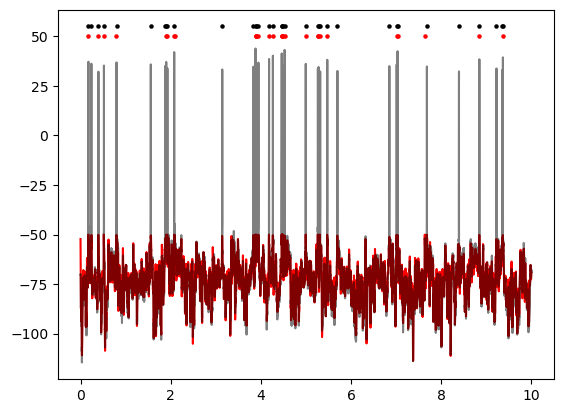

In [52]:
p_time = 10
plt.scatter(t[:p_time*20000]/1000,data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000]/1000,model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t[:p_time*20000]/1000,fitted_voltage[:p_time*20000]*1000,c='red')
plt.plot(t[:p_time*20000]/1000,experiment.V[:p_time*20000],alpha=0.5,c='black')


In [53]:
print('RMS ',rms(fitted_voltage*1000, experiment.V)[0])
print('Explained Variance', var_explained(fitted_voltage*1000, experiment.V))
print('gamma ',get_gamma_factor(model_spike_times,data_spike_times,5,100,1/20))

RMS  4.323858135954192
Explained Variance 0.8472829979404906
gamma  0.010902233484589519


## LIF2

{'El': -0.05567769482316576,
 'C': 2.8551291772222157e-11,
 'G': 8.374981041089867e-09,
 'Th_inf': -0.04519947066867802,
 't_ref': 0.004037025498836038,
 'a_r': 0.7554509048260304,
 'b_r': -0.05339671506825579,
 'a_s': -0.010350539109694365,
 'b_s': 78.652277274793}

In [84]:

# 'El' :-0.054107081692151136,    
# 'C':2.856582627363217e-11, 
# 'G':8.373039461168674e-09, 
# 't_ref':-0.04527416056513923, 
# 'Th_inf':0.0045239157501389335, 
# 'a_r': 0.3724989447937439, 
# 'b_r':-0.07779929218140384, 
# 'a_s':-0.01040850002476415,
# 'b_s': 89.05937992688483   


list_g2 =  [-0.05567769482316576, 2.8551291772222157e-11, 8.374981041089867e-09, -0.04519947066867802, 0.004037025498836038, 0.7554509048260304, -0.05339671506825579, -0.010350539109694365, 78.652277274793]
params_init = parameters_from_list_g2(list_g2)
params_init['Th_s'] = -0.055
# params_init = {
#             'El':-0.052249,
#                'C':28e-12,
#                'G':8.3745e-9,
#                'Th_inf':-0.045767902388055545,
#                't_ref':0.004,
#                'Th_s':-0.04,
#                'a_r':  0.3724989447937439,         
#                'b_r': -0.07779929218140384,
#                'a_s': -0.01040850002476415,
#                'b_s':  89.05937992688483,       
#                } 
brian2.start_scope()
 
params_init_with_units = add_parameter_units_g2(params_init)
# print(params_init_with_units)
t, fitted_voltage,th_s, spks = GLIF2_sim(stim = experiment.I*b2.pA,
                                    param_dict=params_init_with_units,
                                init_values={'V_init':params_init['El'],'Th_s':params_init['Th_s']}, 
                                dt=1/20000*b2.second, )




running  26336
finished  26336


In [85]:
print(params_init_with_units)

{'El': -55.67769482 * mvolt, 'C': 28.55129177 * pfarad, 'G': 8.37498104 * nsiemens, 'Th_inf': -45.19947067 * mvolt, 't_ref': 4.0370255 * msecond, 'a_r': 0.7554509048260304, 'b_r': -53.39671507 * mvolt, 'a_s': -10.35053911 * mvolt, 'b_s': 78.65227727 * hertz}


In [86]:

data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,data_spike_times,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,model_spike_times,experiment.dt,type='nan')

In [89]:
print('RMS ',rms(fitted_voltage*1000, experiment.V)[0])
print('Explained Variance', var_explained(fitted_voltage*1000, experiment.V))
print('gamma ',get_gamma_factor(model_spike_times,data_spike_times,5,100,1/20))


RMS  6.014834515303356
Explained Variance 0.7044765940761311
gamma  0.6626134941769065


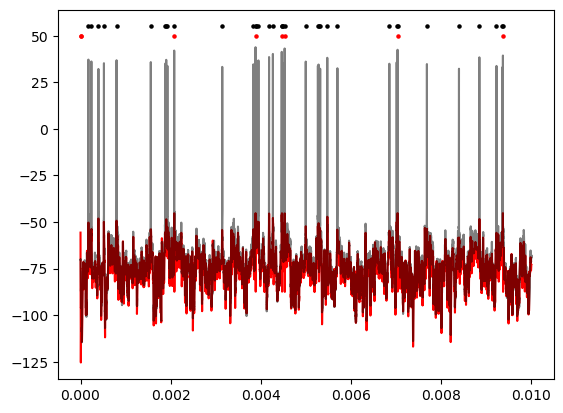

In [90]:
p_time = 10
plt.scatter(t[:p_time*20000]/1000,data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000]/1000,model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t[:p_time*20000]/1000,fitted_voltage[:p_time*20000]*1000,c='red')
plt.plot(t[:p_time*20000]/1000,experiment.V[:p_time*20000],alpha=0.5,c='black')


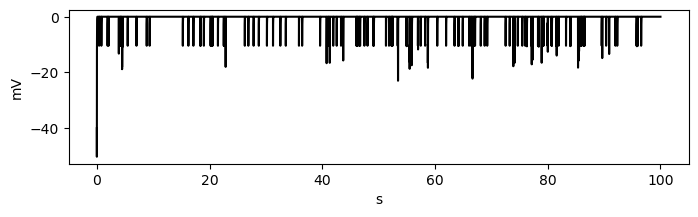

In [59]:
fig,ax1 = plt.subplots(1,figsize=[8,2])

ax1.plot(t,th_s/1e-3,c='black')
ax1.set_xlabel('s')
ax1.set_ylabel('mV')
plt.show()



## GLIF3

In [60]:

params_init = {'V_init':-0.052249,
               'I_0':10e-12,
               'I_1':10e-12,
                }

# list_params = [-0.05251569477710258, 2.7004212106702223e-11, 8.346770297273584e-09, -0.04767937964296501, 0.00402376079399319, -0.05047090142809699, 9.909019765855576e-12, 76.85296987185038, 0.14919372715935453, 4.201884209678848e-12, 84.17400584078261, 3.0413037833924417]
list_params = [-0.05251569477710258, 2.7004212106702223e-11, 8.346770297273584e-09,-0.04767937964296501, 
0.00402376079399319, -0.05047090142809699, 9.909019765855576e-12, 76.85296987185038, 0.14919372715935453, 4.201884209678848e-12, 84.17400584078261, 3.0413037833924417]  
params = parameters_from_list_g3(list_params)
print(params)


# params = {'El': -0.05251569477710258, 
# 'C': 2.7004212106702223e-11, 
# 'G': 8.346770297273584e-09, 
# 'Th_inf': -0.04767937964296501, 
# 't_ref': 0.00402376079399319, 
# 'V_reset': -0.05047090142809699, 
# 'A_0': 9.909019765855576e-12, 
# 'k_0': 76.85296987185038,    
# 'R_0': 0.14919372715935453,  
# 'A_1': 4.201884209678848e-12, 
# 'k_1': 84.17400584078261,    
# 'R_1': 3.0413037833924417}   


brian2.start_scope()
 
params_init_with_units = add_parameter_units_g3(params)

t, fitted_voltage, I_0, I_1,spks = GLIF3_sim(stim = experiment.I*b2.pA,
                                            param_dict=params_init_with_units,
                                            init_values={'V_init':params['El'],
                                                        'I_0':params_init['I_0'],
                                                        'I_1':params_init['I_1']}, 
                                            dt=1/20000*b2.second, )


{'El': -0.05251569477710258, 'C': 2.7004212106702223e-11, 'G': 8.346770297273584e-09, 'Th_inf': -0.04767937964296501, 't_ref': 0.00402376079399319, 'V_reset': -0.05047090142809699, 'A_0': 9.909019765855576e-12, 'k_0': 76.85296987185038, 'R_0': 0.14919372715935453, 'A_1': 4.201884209678848e-12, 'k_1': 84.17400584078261, 'R_1': 3.0413037833924417}
running  26336
finished  26336


In [61]:

data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
print('RMS:',rms(fitted_voltage,experiment.V/1000)[0])
print('Var Explained:',var_explained(fitted_voltage,experiment.V/1000))
print('gamma:',get_gamma_factor(model_spike_times,data_spike_times,4,1000,1/20))




RMS: 0.004171901880286004
Var Explained: 0.8578284532809335
gamma: 0.026574803149606363


In [62]:

data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,experiment.spiketimes,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,np.array(spks.spike_trains()[0])*1000,experiment.dt,type='nan')

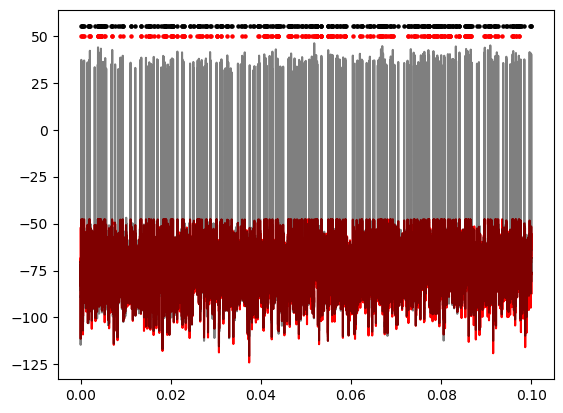

In [63]:
p_time = 100
plt.scatter(t[:p_time*20000]/1000,data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000]/1000,model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t[:p_time*20000]/1000,fitted_voltage[:p_time*20000]*1000,c='red')
plt.plot(t[:p_time*20000]/1000,experiment.V[:p_time*20000],alpha=0.5,c='black')


Text(0, 0.5, 'pA')

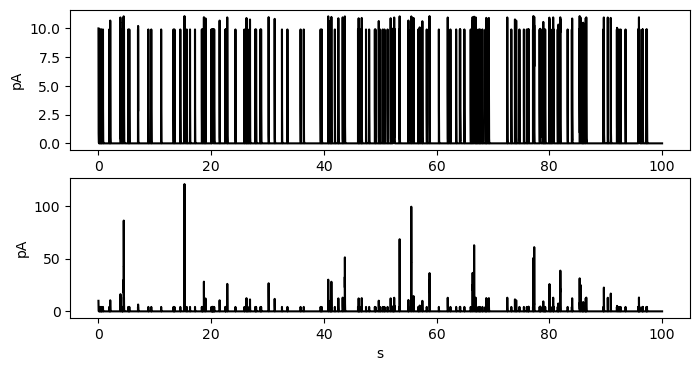

In [64]:
fig,[ax1,ax2] = plt.subplots(2,figsize=[8,4])

ax1.plot(t,I_0/1e-12,c='black')
ax1.set_xlabel('s')
ax1.set_ylabel('pA')

ax2.plot(t,I_1/1e-12,c='black')
ax2.set_xlabel('s')
ax2.set_ylabel('pA')




## GLIF4

In [65]:
params = {'El':    -0.05251569477710258 ,  
          'C':      2.7004212106702223e-11, 
          'G':      8.346770297273584e-09 , 
          'Th_inf':-0.04767937964296501,   
          't_ref':  0.00402376079399319 ,   
          'a_r':    0.3724989447937439,
          'b_r':   -0.07779929218140384, 
          'a_s':   -0.01040850002476415, 
          'b_s':    89.05937992688483,  
          'A_0':    9.909019765855576e-12, 
          'k_0':    76.85296987185038,     
          'R_0':    0.14919372715935453,    
          'A_1':    4.201884209678848e-12,  
          'k_1':    84.17400584078261,       
          'R_1':    3.0413037833924417          
          }  
 



list_params =  [-0.05239229983829609, 2.7457524442540904e-11, 8.372537181299928e-09, -0.03697145084777033, 0.00354588497455033, 2.554331640736145, -0.05127287744858531, -0.015476575349934046, 38.182303345052425, 2.9493945741755203e-12, 42.269445900713464, 2.9137883496110453, 2.9952249964573154e-12, 43.844970605692154, 49.586266015771244]


# params = parameters_from_list_g4(list_params)
params_init = {'V_init':params['El'],
               'I_0':1e-12,
               'I_1':1e-12,
               'Th_s': -30/1000}
params_init_with_units = add_parameter_units_g4(params)
print(params_init_with_units)
brian2.start_scope()

t, fitted_voltage, Th_s,  I_0, I_1,spks = GLIF4_sim(stim = experiment.I*b2.pA,
                                                    param_dict=params_init_with_units,
                                                    init_values={'V_init':params_init['V_init'],
                                                                 'I_0':   params_init['I_0'],
                                                                 'I_1':   params_init['I_1'],
                                                                 'Th_s':  params_init['Th_s']}, 
                                                    dt=1/20000*b2.second,)

{'El': -52.51569478 * mvolt, 'C': 27.00421211 * pfarad, 'G': 8.3467703 * nsiemens, 'Th_inf': -47.67937964 * mvolt, 't_ref': 4.02376079 * msecond, 'a_r': 0.3724989447937439, 'b_r': -77.79929218 * mvolt, 'a_s': -10.40850002 * mvolt, 'b_s': 89.05937993 * hertz, 'A_0': 9.90901977 * pamp, 'k_0': 76.85296987 * hertz, 'R_0': 0.14919372715935453, 'A_1': 4.20188421 * pamp, 'k_1': 84.17400584 * hertz, 'R_1': 3.0413037833924417}
running  26336


WARNING    'dt' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 50. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


finished  26336


In [66]:
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,experiment.spiketimes,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,np.array(spks.spike_trains()[0])*1000,experiment.dt,type='nan')

In [67]:
print('RMS',rms(fitted_voltage,experiment.V/1000)[0])
print('Var Explained',var_explained(fitted_voltage,experiment.V/1000))
print('Gamma',get_gamma_factor(model_spike_times,data_spike_times,4,10*1000,1/20))

RMS 0.007207173019467026
Var Explained 0.5756986503567283
Gamma 0.4143616923388358


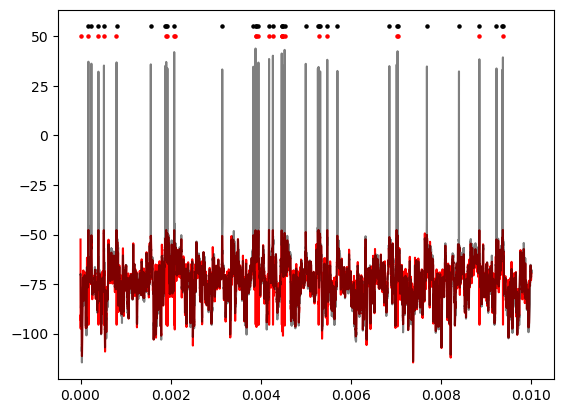

In [68]:
p_time = 10
plt.scatter(t[:p_time*20000]/1000,data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000]/1000,model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t[:p_time*20000]/1000,fitted_voltage[:p_time*20000]*1000,c='red')
plt.plot(t[:p_time*20000]/1000,experiment.V[:p_time*20000],alpha=0.5,c='black')


Text(0.5, 1.0, 'I_1')

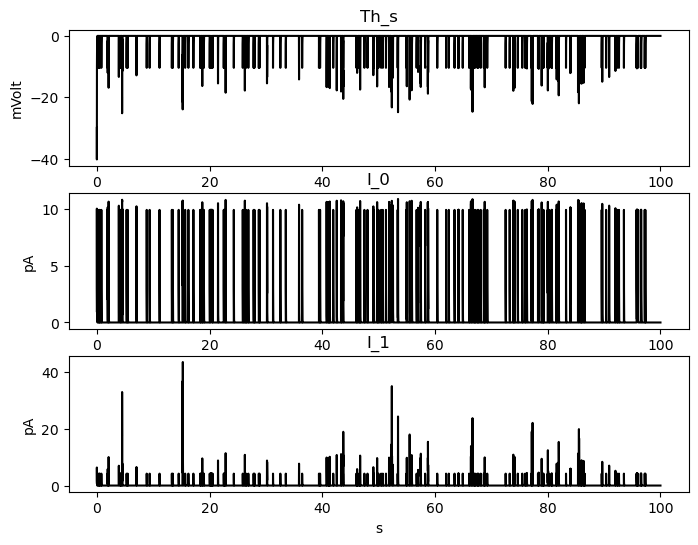

In [69]:
fig,[ax1,ax2,ax3] = plt.subplots(3,figsize=[8,6])
ax1.plot(t,Th_s/1e-3,c='black')
ax1.set_ylabel('mVolt')
ax1.set_title('Th_s')
ax2.plot(t,I_0/1e-12,c='black')
# ax2.set_xlabel('s')
ax2.set_ylabel('pA')
ax2.set_title('I_0')

ax3.plot(t,I_1/1e-12,c='black')
ax3.set_xlabel('s')
ax3.set_ylabel('pA')
ax3.set_title('I_1')




## GLIF 5

In [70]:
params = {'El':     -0.05251569477710258 ,   
          'C':       2.7004212106702223e-11, 
          'G':       8.346770297273584e-09 , 
          't_ref':   0.00402376079399319 ,   
          'Th_inf': -0.04767937964296501,    
          'V_reset':-0.055354,              
          'a_r':     0.3724989447937439,      #none
          'b_r':    -0.07779929218140384,     #volt
          'a_s':    -0.01040850002476415,     #volt
          'b_s':     89.05937992688483,       #hertz
          'a_v':     0.1                ,     #hertz
          'b_v':     0.03                ,    #hertz
          'A_0':     9.909019765855576e-12,   #amp
          'k_0':     76.85296987185038,       #hertz        
          'R_0':     0.14919372715935453,     #none
          'A_1':     4.201884209678848e-12,   #amp
          'k_1':     84.17400584078261,       #hertz  
          'R_1':     3.0413037833924417}      #none


params_init = {'V_init':params['El'],
               'I_0':1e-12,
               'I_1':1e-12,
               'Th_s': -30/1000,
               'Th_v': -30/1000}

list_params =[-0.052820178961550286, 2.821001644268705e-11, 8.3705179677193e-09, -0.038164480631923965, 0.004655631327142665, 0.8634672839389688, -0.07766399819865118, -0.010172801732151323, 49.894021956938154, 16.238474952251323, 71.09106711425905, 6.31874956593662e-12, 67.12419285789896, 22.78791220172908, 3.742010200464058e-12, 42.39117467603052, 99.04081162535275]
params = parameters_from_list_g5(list_params)

params_init_with_units = add_parameter_units_g5(params)
print(params_init_with_units)
brian2.start_scope()

t, fitted_voltage, Th_s, Th_v, I_0, I_1,spks = GLIF5_sim(stim = experiment.I*b2.pA,
                                                         param_dict=params_init_with_units,
                                                         init_values={'V_init':params_init['V_init'],
                                                                      'I_0':   params_init['I_0'],
                                                                      'I_1':   params_init['I_1'],
                                                                      'Th_s':  params_init['Th_s'],
                                                                      'Th_v':  params_init['Th_v']}, 
                                                         dt=1/20000*b2.second)

{'El': -52.82017896 * mvolt, 'C': 28.21001644 * pfarad, 'G': 8.37051797 * nsiemens, 'Th_inf': -38.16448063 * mvolt, 't_ref': 4.65563133 * msecond, 'a_r': 0.8634672839389688, 'b_r': -77.6639982 * mvolt, 'a_s': -10.17280173 * mvolt, 'b_s': 49.89402196 * hertz, 'a_v': 16.23847495 * hertz, 'b_v': 71.09106711 * hertz, 'A_0': 6.31874957 * pamp, 'k_0': 67.12419286 * hertz, 'R_0': 22.78791220172908, 'A_1': 3.7420102 * pamp, 'k_1': 42.39117468 * hertz, 'R_1': 99.04081162535275}
running  26336


WARNING    neurongroup's variable 'Th_v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup's variable 'V' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


finished  26336


In [71]:
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,data_spike_times,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,model_spike_times,experiment.dt,type='nan')

In [72]:
print('RMS',rms(fitted_voltage,experiment.V/1000)[0])
print('Var Explained',var_explained(fitted_voltage,experiment.V/1000))
print('Gamma',get_gamma_factor(model_spike_times,data_spike_times,4,1000,1/20))

WARNING    C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_26336\1817017660.py:77: RuntimeWarning: overflow encountered in square
  return [np.sqrt(np.mean((val1-val2)**2))]
 [py.warnings]
WARNING    C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_26336\1817017660.py:80: RuntimeWarning: overflow encountered in square
  return 1- (np.mean((data-model)**2)/np.mean((data-np.mean(data))**2))
 [py.warnings]


RMS inf
Var Explained -inf
Gamma 0.018391330891330826


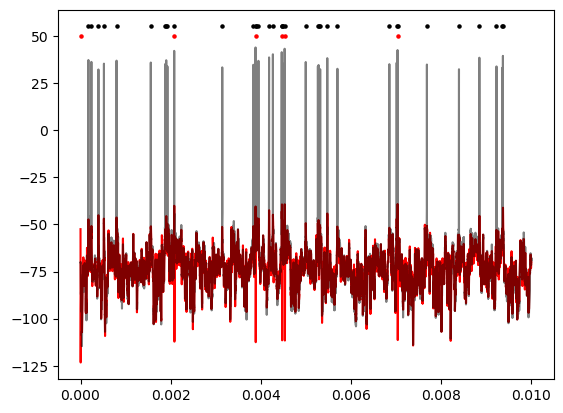

In [73]:
p_time = 10
plt.scatter(t[:p_time*20000]/1000,data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000]/1000,model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t[:p_time*20000]/1000,fitted_voltage[:p_time*20000]*1000,c='red')
plt.plot(t[:p_time*20000]/1000,experiment.V[:p_time*20000],alpha=0.5,c='black')


WARNING    C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_26336\3131898623.py:5: RuntimeWarning: overflow encountered in divide
  ax2.plot(t,Th_v/1e-3,c='black')
 [py.warnings]
WARNING    C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_26336\3131898623.py:12: RuntimeWarning: overflow encountered in divide
  ax4.plot(t,I_1/1e-12,c='black')
 [py.warnings]


Text(0, 0.5, 'pAmp')

WARNING    c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
 [py.warnings]


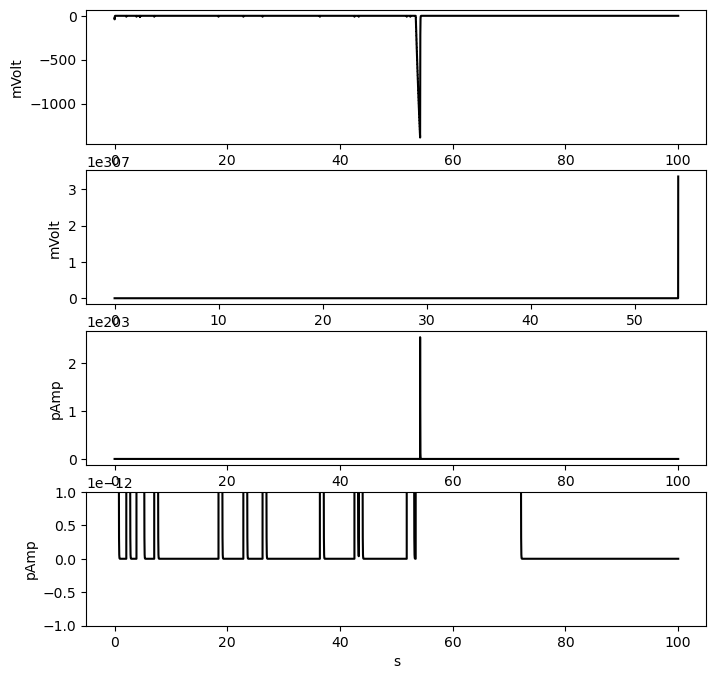

In [74]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(4,figsize=[8,8])
ax1.plot(t,Th_s/1e-3,c='black')
ax1.set_ylabel('mVolt')

ax2.plot(t,Th_v/1e-3,c='black')
ax2.set_xlabel('s')
ax2.set_ylabel('mVolt')

ax3.plot(t,I_0/1e-12,c='black')
ax3.set_ylabel('pAmp')

ax4.plot(t,I_1/1e-12,c='black')
ax4.set_xlabel('s')
ax4.set_ylabel('pAmp')

In [75]:
import brian2 as b
from brian2.units import ms, mV, nA, nS, pA, pF

from dendrify import PointNeuronModel

b.prefs.codegen.target = 'numpy'  # faster for simple simulations
b.seed(1234)  # for reproducibility

# Create neuron model
model = PointNeuronModel(model='adex',
                         cm_abs=28*pF,
                         gl_abs=8*nS,
                         v_rest=-55.354*mV)

model.add_params({'Vth': -50.4*mV,
                  'DeltaT': 2*mV,
                  'tauw': 144*ms,
                  'a': 4*nS,
                  'b': 0.0805*nA,
                  'Vr': -70.6*mV})

# Create a NeuronGroup
neuron = model.make_neurongroup(N=1, threshold='V>Vth+5*DeltaT',
                                reset='V=Vr; w+=b',
                                method='euler')

# Update model with noise and create a new NeuronGroup
model.noise(mean=50*pA, sigma=300*pA, tau=2*ms)
noisy_neuron = model.make_neurongroup(N=1, threshold='V>Vth+5*DeltaT',
                                      reset='V=Vr; w+=b',
                                      method='euler')

# Record voltages and spike times
trace = b.StateMonitor(neuron, 'V', record=True)
spikes = b.SpikeMonitor(neuron)
noisy_trace = b.StateMonitor(noisy_neuron, 'V', record=True)
noisy_spikes = b.SpikeMonitor(noisy_neuron)

# Run simulation
neuron.I_ext = experiment.I

b.run(len(experiment.I)/20 * ms)

# Trick to draw nicer spikes in I&F models
vm = trace[0].V[:]
noisy_vm = noisy_trace[0].V[:]
for t1, t2 in zip(spikes.t, noisy_spikes.t):
    i = int(t1 / b.defaultclock.dt)
    j = int(t2 / b.defaultclock.dt)
    vm[i] = 20*mV
    noisy_vm[j] = 20*mV

# Plot results
fig, axes = b.subplots(2, 1, figsize=[6, 6])
ax1, ax2 = axes
ax1.plot(trace.t / ms, vm / mV, label='V')
ax1.set_ylabel('Voltage (mV)')
ax1.legend()

ax2.plot(noisy_trace.t / ms, noisy_vm / mV, label='V (with noise)')
ax2.set_ylabel('Voltage (mV)')
ax2.set_xlabel('Time (ms)')
ax2.legend()
fig.tight_layout()
b.show()

DimensionMismatchError: I_ext should be set with a value with units amp, but got [-150.         -150.         ... -191.27446726 -190.86377945] (unit is 1).